# 1. Introduction and General Information

In this project, we analyze the LastFM dataset released in the framework of HetRec 2011 (http://ir.ii.uam.es/hetrec2011). This dataset contains an underlying social network, artists tags given by users, and user-artist listening count from a set of 1892 users and 17632 artists. Different type of files are given, describing the interactions between user-user, user-artist and tags. Our aim is to test whether friendship implies similar taste in music, in other words whether friends do tend to listen to the same music. 

We approach the problem in two different ways:
- We construst a network based on the similarity between artists and from it we try to infer user-user connections.
- We build a recommender system based on only the listening counts and then try to improve it using the underlying friendship network or the artist-artist similarity network.

In [32]:
%load_ext autoreload
%autoreload 1

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import os.path
import networkx as nx
from scipy.sparse import csr_matrix
from Dataset import Dataset
from plots import *
import os
from helpers import *
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Exploration

In this section we analyze our dataset that has the following structure: for each user there is a list of his/her favorite artists, each listened artist has a listening record denoting the listening times; for each artist there is a list of his/her genre, which is a list of tags given by users that have listened to the artist. In addition we have for each user a list of his friends.

The goal is to show the initial insights and the motivation, but the final processing is contained in the Dataset module whos' functions are called in each section to produce the dataset that is used throughout the notebook.

In [2]:
# Loading the data
data = Dataset()
data_folder = os.path.join('.','data')
ratings_path = os.path.join(data_folder,'user_artists.dat')
ratings = pd.read_csv(ratings_path, sep='\t', header=0, skipinitialspace=True)

In [3]:
data.artists.head()

,name,url,pictureURL
id,,,
1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


### Tag analysis

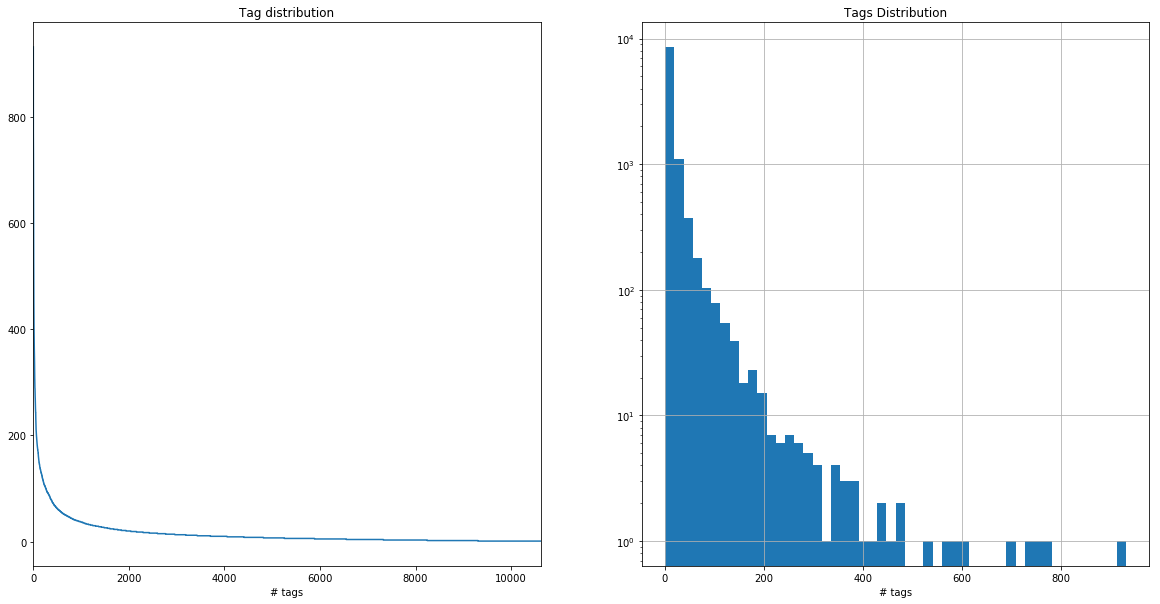

In [4]:
group = data.tags_assign[['artistID','tagID']].groupby(['artistID'])

group = group.size()
group.sort_values(ascending=False,inplace=True)

plot_tags_statistics(group)

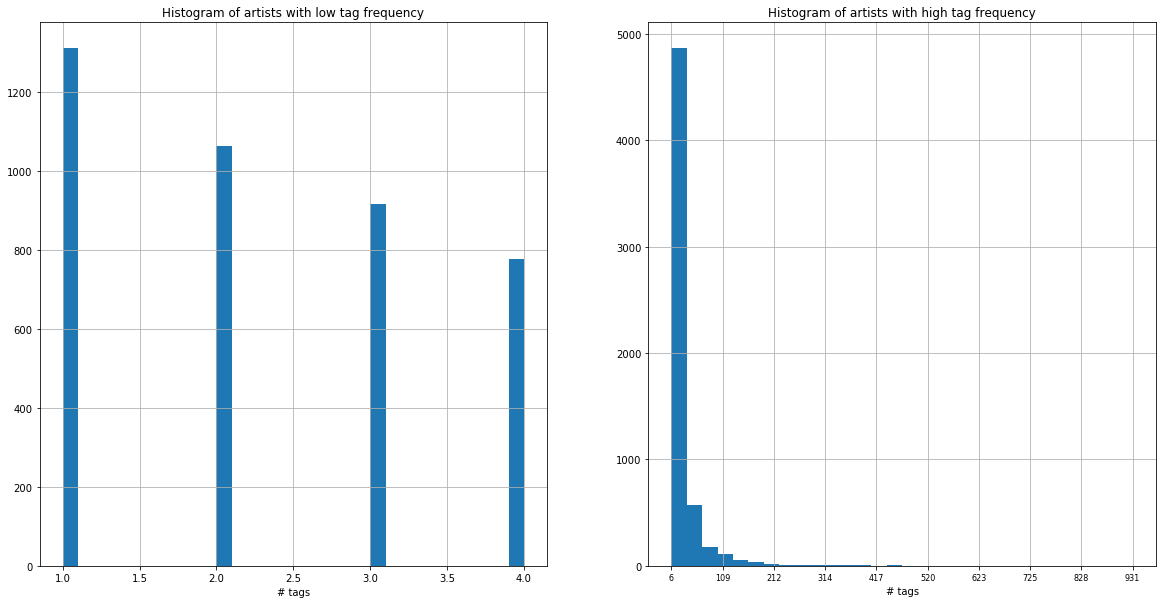

In [5]:
small = group.loc[group<5]
big = group.loc[group>5]

plot_separate_small_artist(small, big)

It can be observed that there are no artists with zero tags and most of the artists have more than 5 tags.

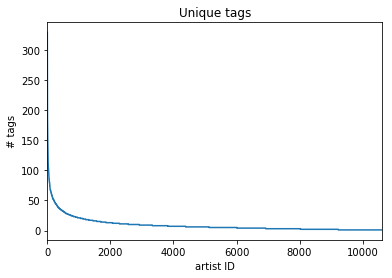

In [6]:
group = data.tags_assign[['artistID','tagID']].groupby(['artistID'])

group = group.nunique().tagID.sort_values(ascending=False)

plot_unique_tags(group)

From the above plot we can observe that for each artist we have a certain number of different tags but since LastFM tags are freeform a part of them can have the same meaning while written in different form, e.g., 90 -> 90' -> 90s or can have meaning that is identifiable only by the user itself.

### Listening count analysis

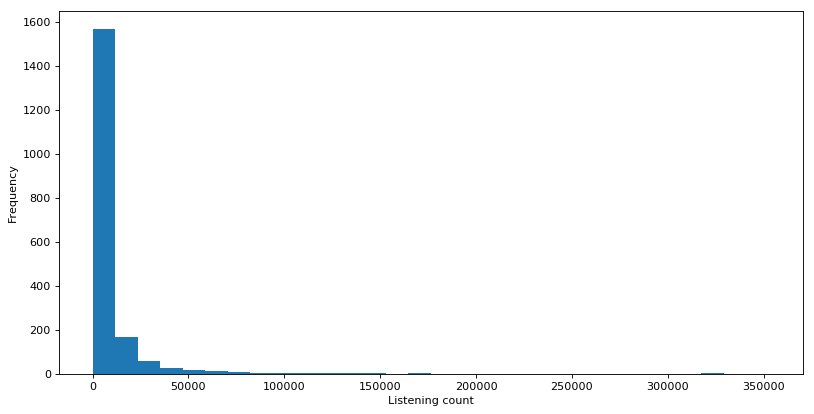

In [7]:
max_user_weight = data.ratings.groupby('userID').max()

plot_listenig_count_frequency(max_user_weight)

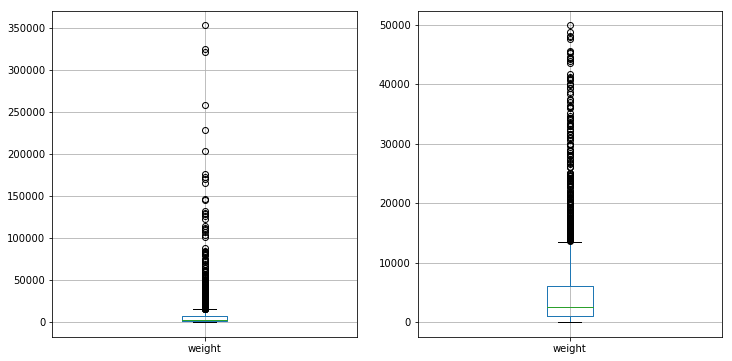

In [8]:
max_user_weight = data.ratings.groupby('userID').max()
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
plt.subplot(1, 2, 1)
max_user_weight.boxplot(column='weight')
plt.subplot(1,2,2)
max_user_weight.loc[max_user_weight['weight']<=50000].boxplot(column='weight');

We can see from the plot above that most of the users have a maximum listening count of less than 50,000, while some of them are significantly higher. Observing such high listening counts for 1 artist seems highly unprobable and such activity looks suspicious, possibly motivated by commercial purposes, hence excluded.

In [9]:
print("The number of users with less than a maximum of 50,000 listening count:",\
      len(max_user_weight.loc[max_user_weight['weight']<=50000]))

percentage = len(max_user_weight.loc[max_user_weight['weight']<=50000])/ len(max_user_weight)*100
print("Percentage of total users:", \
     percentage ,"%")

The number of users with less than a maximum of 50,000 listening count: 1827
Percentage of total users: 96.87168610816543 %


A function that prunes the listening counts.

In [10]:
data.prune_ratings()

72  users dropped in weights pruning


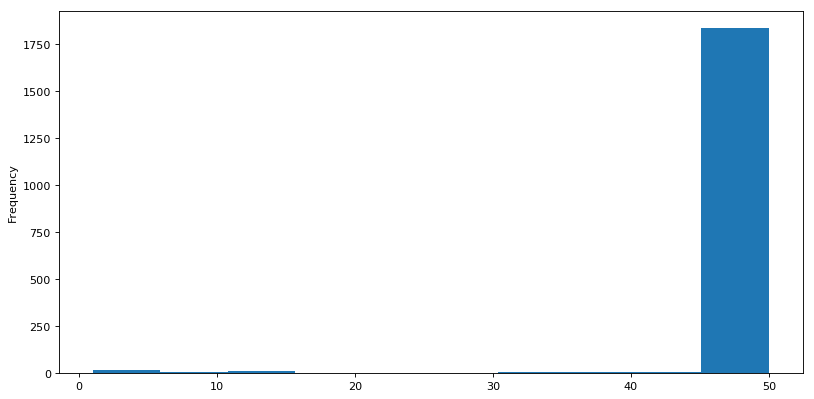

In [11]:
number_user_artist =ratings.groupby('userID').nunique().artistID.to_frame()

plot_artist_per_user(number_user_artist)

The plot shows that most of the users have around 50 artist connections. We decided to remove the users who listened to less than 10 different artists. (The motivation to keep all the users with artist connections above 10 will be shown later, since the distribution of artists changes slightly after a small reduction in the artist-artist similarity network construction.) 

### User-User network

In this section we analyze the lastFm social network.

In [12]:
#G is the total graph with all users ,except the one already pruned, and multiple component
G = nx.Graph(data.build_friend_friend())

print('My network has {} nodes.'.format(len(G.nodes())))
print('My network has {} edges.'.format(G.size()))

My network has 1820 nodes.
My network has 11218 edges.


In [13]:
nx.is_connected(G)

False

In [14]:
connected_components = nx.connected_components(G)
for i, subgraph in enumerate(sorted(connected_components, key = len, reverse=True)):
    print("Subgraph {} has {} nodes" .format(i, len(subgraph)))

Subgraph 0 has 1747 nodes
Subgraph 1 has 7 nodes
Subgraph 2 has 4 nodes
Subgraph 3 has 3 nodes
Subgraph 4 has 3 nodes
Subgraph 5 has 3 nodes
Subgraph 6 has 3 nodes
Subgraph 7 has 3 nodes
Subgraph 8 has 2 nodes
Subgraph 9 has 2 nodes
Subgraph 10 has 2 nodes
Subgraph 11 has 2 nodes
Subgraph 12 has 2 nodes
Subgraph 13 has 2 nodes
Subgraph 14 has 2 nodes
Subgraph 15 has 2 nodes
Subgraph 16 has 2 nodes
Subgraph 17 has 2 nodes
Subgraph 18 has 2 nodes
Subgraph 19 has 2 nodes
Subgraph 20 has 2 nodes
Subgraph 21 has 1 nodes
Subgraph 22 has 1 nodes
Subgraph 23 has 1 nodes
Subgraph 24 has 1 nodes
Subgraph 25 has 1 nodes
Subgraph 26 has 1 nodes
Subgraph 27 has 1 nodes
Subgraph 28 has 1 nodes
Subgraph 29 has 1 nodes
Subgraph 30 has 1 nodes
Subgraph 31 has 1 nodes
Subgraph 32 has 1 nodes
Subgraph 33 has 1 nodes
Subgraph 34 has 1 nodes
Subgraph 35 has 1 nodes
Subgraph 36 has 1 nodes
Subgraph 37 has 1 nodes
Subgraph 38 has 1 nodes
Subgraph 39 has 1 nodes
Subgraph 40 has 1 nodes
Subgraph 41 has 1 nodes

The User social network graph is composed of 29 disconnected subgraphs. Fortunately most of the user (~ 97.5 %) are inside one subgraph, so we can discard all the others in order to have a connected graph.

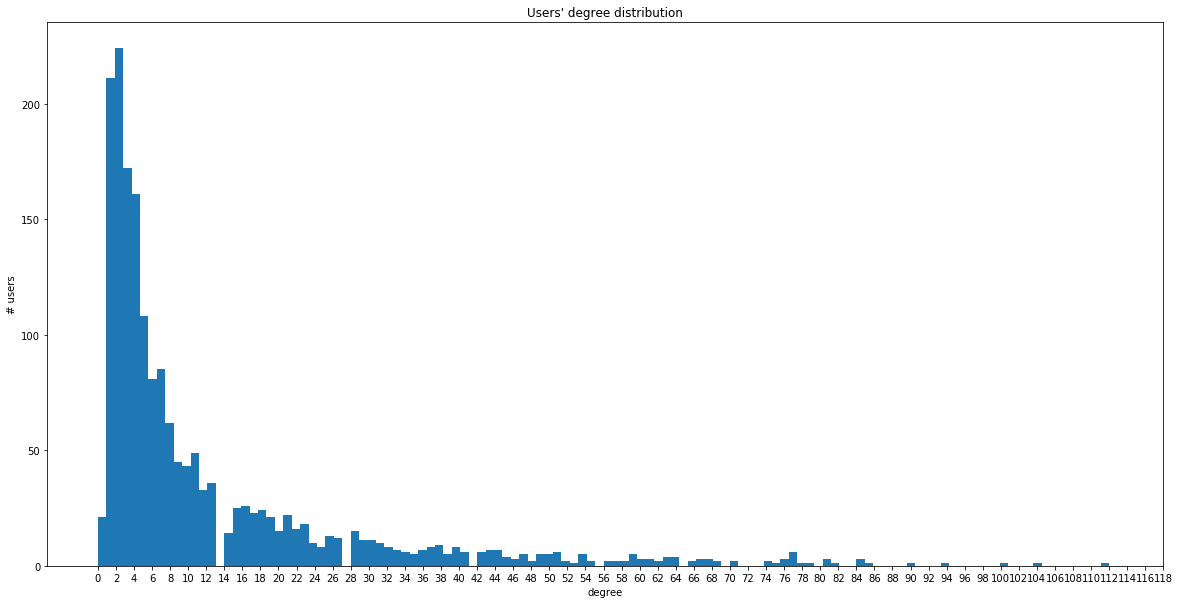

In [15]:
degree_distribution(G.degree())

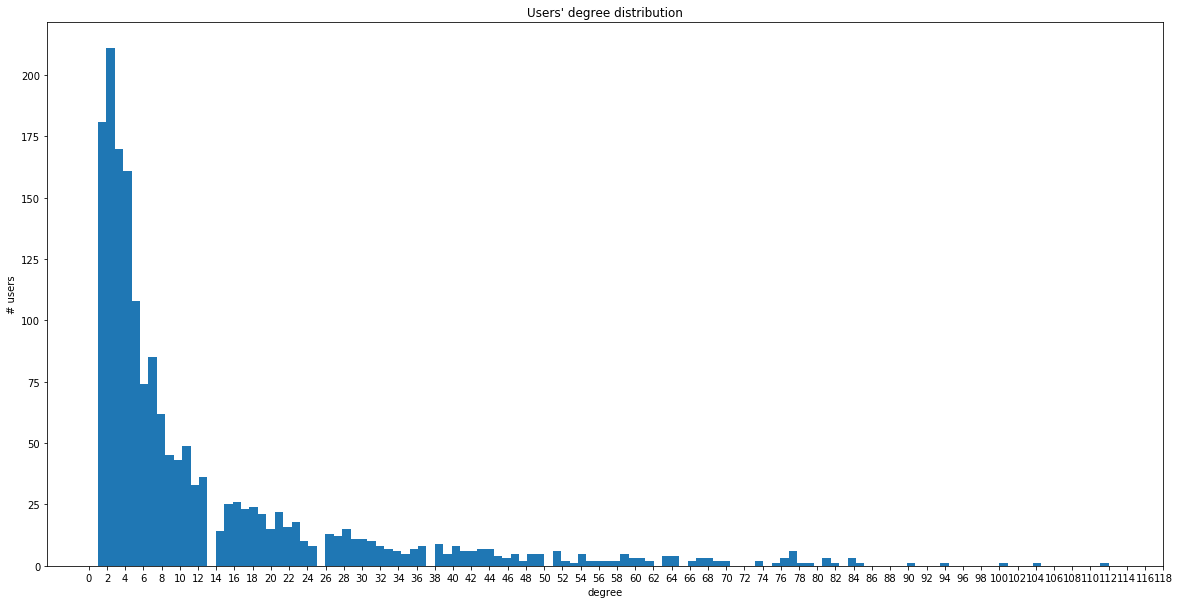

My network has 1747 nodes.
My network has 11166 edges.


In [16]:
graphs = list(nx.connected_component_subgraphs(G))
#giant component is the graph which contains most of the users
giant_component = graphs[0]

degree_distribution(giant_component.degree())

print('My network has {} nodes.'.format(len(giant_component.nodes())))
print('My network has {} edges.'.format(giant_component.size()))

As we can observe the degree distribution is mostly unchanged, we only have a little decrease of the number of user with very small connections since the subgraphs we deleted were composed of few users. The function below updates the dataset by reducing the dataset to its largest connected component.

In [17]:
data.prune_friends()

73  users dropped in friendship pruning


### Weight Normalization
We need to build a similarity graph for collaborative filtering. We need to understand which artists users listen to and not necessarely how much. Even though taking into account the absolute value of listening counts could have been a measure of how much we can trust a user preferences, we decided to normalize separately for each user in order to keep the weights simple and clear. In particular we model the normalized weight as the ratio the listening count and the biggest listening count for each user. Thus, all the weights of a user are less or equal to 1.

In [18]:
data.normalize_weights()

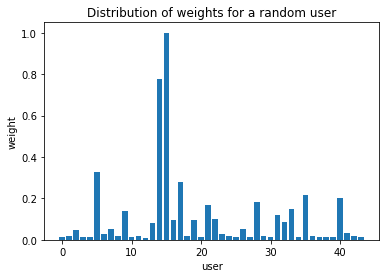

In [19]:
# Plot distribution of weights for a random user
user_weight_distribution(data.ratings, seed=1)

# 1. Friendship inference from music taste

These are the steps we followed to build the user-user comparison network:
* Construct an artist similarity graph and connect the users to artists using the normalized listening count.


* For each user consider all the possible direct paths  $u_i \rightarrow a_k \rightarrow u_j$ and 3-hop paths $u_i \rightarrow a_k \rightarrow a_l \rightarrow u_j$ where the $u_i \rightarrow a_k$ and $a_l \rightarrow u_j$ are weighted with the respective normalized weight (call them $C_{ik}$ and $C_{jl}$) while the weight between the two artists represents the strength of the similarity taken from the constructed similiraty graph (call it $S_{kl}$).


* Add an edge between each pair $u_i$ and $u_j$ with a weight equal to: $F_{ij} = \sum\limits_{k,l \in \Omega} S_{kl}\min\{C_{ik}, C_{jl}\} + \sum\limits_{k \in \Theta}\min\{C_{ik}, C_{jk}\}$ where $\Omega$ is the set of all artists that are similar to each other out of which one is connected to i and one is connected to j, and  $\Theta$ is the set of all artists that are connected to both users.


* To inspect the connection between the taste in music (listening counts) and the friendships in the underlined network, a random network following the same degree distribution of the artist  similarity network is constructed and the user-user network generated as previously described from this random network is compared to the output generated from the meaningful artist similarity network. 

This [article](https://musicalist.hypotheses.org/236) describes the reason why LastFM enforces their tagging policy and why the tags generated in that way are a meaningful source of information.
Since the data exploration of the tags dataset showed that all of the artists have been tagged we were motivated to use the tags assigned to each artist to infer similarity between them. Before acting, it was noticed that their api offers a function that retrieves similar artists for a given mbid unique code that identifies an artist. All the details are contained in the api notebook.

## Creating the friendship network

In [20]:
data = Dataset()
data.prune_ratings()
data.prune_friends()
data.normalize_weights()

72  users dropped in weights pruning
73  users dropped in friendship pruning


In [21]:
friendship = data.build_friend_friend()

Checking symmetry of the friendship matrix.

In [22]:
np.nonzero(friendship-friendship.transpose())

(array([], dtype=int64), array([], dtype=int64))

In [23]:
friendship.shape

(1747, 1747)

Creating the friendship graph.

In [24]:
friendship_graph = nx.Graph(friendship)

## Creating the artist-artist network

In [25]:
artist_artist_matrix = data.build_art_art()

Checking symmetry of the friendship matrix.

In [26]:
np.nonzero(artist_artist_matrix-artist_artist_matrix.transpose())

(array([], dtype=int64), array([], dtype=int64))

In [27]:
artist_artist_matrix.shape

(13106, 13106)

Creating the artist-artist graph.

In [28]:
artist_artist_graph = nx.Graph(artist_artist_matrix)

## Creating the user-artist network

In [29]:
user_artist_matrix = data.build_art_user(train_only=False)
user_artist_matrix = np.array(user_artist_matrix.T)

## Inferring the New User-User Network

Using the artist-artist similarity network and the user-artist listening counts, a friendship between users is predicted.

In [30]:
generated_user_user_matrix = generate_user_user_matrix_from_artist_artist_matrix(user_artist_matrix, artist_artist_matrix)
generated_user_user_graph = nx.Graph(generated_user_user_matrix)

Now we generate a random network that follows the degree distribution of the artist-artist similarity network.

In [33]:
artist_artist_random_graph, stub_pairs = greedy_configuration(artist_artist_graph)
artist_artist_random_matrix = np.array(csr_matrix.todense(nx.adjacency_matrix(artist_artist_random_graph)))

We check whether any stubs left unconnected (we shouldn't have any if the configuration works correctlly).

In [34]:
sum(stub_pairs.values()) # should be equal to zero if configuration was successful

0

The generated random artist-artist network is used to predict a new friendship network.

In [35]:
generated_user_user_matrix_from_random_aa = generate_user_user_matrix_from_artist_artist_matrix(user_artist_matrix, artist_artist_random_matrix)
generated_user_user_graph_from_random_aa = nx.Graph(generated_user_user_matrix_from_random_aa)

At this point we have a friendship network that is generated based on the similarity between artists, and another one generated based on a random artist artist graph. We want to test whether users who tend to listen to similar artist, and hence have similar taste of music are friends in the social network.

In [36]:
friendship.sum()

22332.0

In [38]:
generated_user_user_matrix.shape

(1747, 1747)

The total number of detected links is 6254.
The total number of not detected links is 4912.
(445740,)


(array([ 416.,  329.,  259.,  235.,  218.,  153.,   74.,   35.,   20.,    8.]),
 array([   0. ,   90.4,  180.8,  271.2,  361.6,  452. ,  542.4,  632.8,
         723.2,  813.6,  904. ]),
 <a list of 10 Patch objects>)

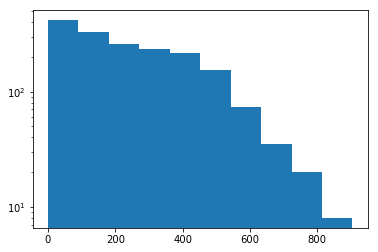

In [45]:
threshold = 0.9999
reduced_matrix = np.zeros((generated_user_user_matrix.shape))
reduced_matrix[generated_user_user_matrix > threshold] = 1
reduced_matrix[generated_user_user_matrix <= threshold] = 0
reduced_graph = nx.Graph(reduced_matrix)
compare_networks(friendship_graph, reduced_graph)
print(generated_user_user_matrix.flatten()[generated_user_user_matrix.flatten() > threshold].shape)
plt.hist(list(dict(reduced_graph.degree()).values()), log=True)

In [ ]:
plt.hist(list(dict(friendship_graph.degree()).values()), log=True)

In [ ]:
threshold = 0.3
reduced_matrix[generated_user_user_matrix_from_random_aa > threshold] = 1
reduced_matrix[generated_user_user_matrix_from_random_aa <= threshold] = 0
reduced_graph = nx.Graph(reduced_matrix)
compare_networks(friendship_graph, reduced_graph)
print(generated_user_user_matrix_from_random_aa.flatten()[generated_user_user_matrix_from_random_aa.flatten() > threshold].shape)
plt.hist(list(dict(reduced_graph.degree()).values()), log=True)